In [1]:
try:
    import recirq
except ImportError:
    !pip install -q git+https://github.com/quantumlib/ReCirq

In [2]:
import cirq
import recirq
import networkx as nx
from cirq.contrib.svg import SVGCircuit
import numpy as np

In [3]:
from pytket.predicates import CompilationUnit, ConnectivityPredicate
from pytket.passes import SequencePass, RoutingPass, DecomposeSwapsToCXs
from pytket.routing import GraphPlacement

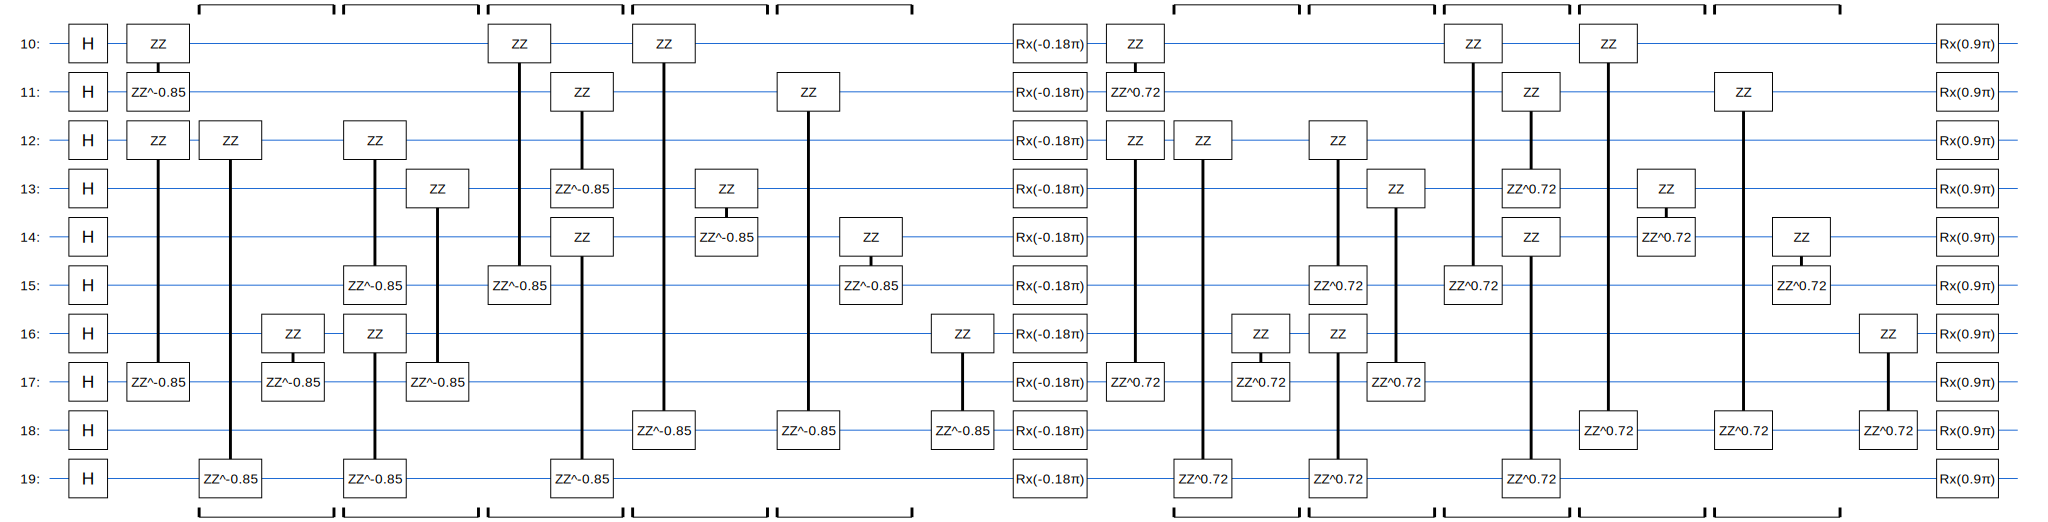

In [4]:
from recirq.qaoa.problem_circuits import get_generic_qaoa_circuit
from recirq.qaoa.gates_and_compilation import compile_problem_unitary_to_arbitrary_zz, \
    compile_driver_unitary_to_rx

problem_graph = nx.random_regular_graph(d=3, n=10)
nx.set_edge_attributes(problem_graph, values=1, name='weight')
circuit_qubits = cirq.LineQubit.range(10, 20)
gammas = np.random.randn(2)
betas = np.random.randn(2)
circuit = get_generic_qaoa_circuit(
    problem_graph=problem_graph,
    qubits=circuit_qubits,
    gammas=gammas,
    betas=betas)
circuit = compile_problem_unitary_to_arbitrary_zz(circuit)
circuit = compile_driver_unitary_to_rx(circuit)
SVGCircuit(circuit)

In [5]:
import recirq

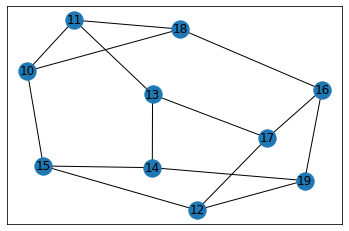

In [6]:
import cirq.contrib.routing as ccr

uncompiled_c_graph = ccr.get_circuit_connectivity(circuit)
nx.draw_networkx(uncompiled_c_graph)

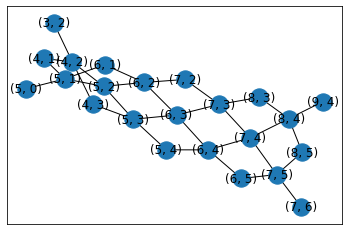

In [7]:
import cirq.google as cg

dev_graph = ccr.xmon_device_to_graph(cg.Sycamore23)
nx.draw_networkx(dev_graph)

In [8]:
# alias for the device. If this notebook were wrapped
# in a function, `circuit` and `device` would be the arguments
device = cg.Sycamore23

In [9]:
index_to_qubit = sorted(device.qubit_set())
qubit_to_index = {q: i for i, q in enumerate(index_to_qubit)}

In [10]:
import pytket
from pytket.circuit import Node

def _qubit_index_edges():
    dev_graph = ccr.xmon_device_to_graph(device)
    for n1, n2 in dev_graph.edges:
        #yield Node('q', n1.row, n1.col), Node('q', n2.row, n2.col)
        yield (qubit_to_index[n1], qubit_to_index[n2])

def _device_to_tket_device():
    arc = pytket.routing.Architecture(
        list(_qubit_index_edges())
    )
    return pytket.device.Device({}, {}, arc)

tk_circuit = pytket.cirq.cirq_to_tk(circuit)
tk_device = _device_to_tket_device()

In [11]:
tk_circuit.qubits

[q[10], q[11], q[12], q[13], q[14], q[15], q[16], q[17], q[18], q[19]]

In [12]:
tk_device.coupling

[(node[0], node[2]),
 (node[2], node[1]),
 (node[2], node[3]),
 (node[2], node[6]),
 (node[1], node[5]),
 (node[3], node[7]),
 (node[6], node[7]),
 (node[6], node[10]),
 (node[5], node[6]),
 (node[5], node[4]),
 (node[5], node[9]),
 (node[9], node[10]),
 (node[7], node[8]),
 (node[7], node[11]),
 (node[10], node[11]),
 (node[10], node[14]),
 (node[8], node[12]),
 (node[11], node[12]),
 (node[11], node[15]),
 (node[14], node[15]),
 (node[12], node[13]),
 (node[12], node[16]),
 (node[15], node[16]),
 (node[15], node[19]),
 (node[13], node[17]),
 (node[16], node[17]),
 (node[16], node[20]),
 (node[19], node[20]),
 (node[17], node[18]),
 (node[17], node[21]),
 (node[20], node[21]),
 (node[20], node[22])]

In [13]:
from pytket.predicates import CompilationUnit, ConnectivityPredicate
from pytket.passes import SequencePass, RoutingPass, DecomposeSwapsToCXs, PlacementPass
from pytket.routing import GraphPlacement

In [14]:
unit = CompilationUnit(tk_circuit, [ConnectivityPredicate(tk_device)])
passes = SequencePass([
    PlacementPass(GraphPlacement(tk_device)),
    RoutingPass(tk_device)])
passes.apply(unit)
valid = unit.check_all_predicates()
assert valid

In [15]:
unit.initial_map

{q[10]: node[7],
 q[11]: node[11],
 q[12]: node[9],
 q[13]: node[3],
 q[14]: node[10],
 q[15]: node[12],
 q[16]: node[0],
 q[17]: node[6],
 q[18]: node[1],
 q[19]: node[2]}

In [16]:
def tk_to_i(tk):
    i = tk.index
    assert len(i) == 1, i
    return i[0]

initial_map = {cirq.LineQubit(tk_to_i(n1)): index_to_qubit[tk_to_i(n2)] for n1, n2 in unit.initial_map.items()}
initial_map

{cirq.LineQubit(10): cirq.GridQubit(5, 3),
 cirq.LineQubit(11): cirq.GridQubit(6, 3),
 cirq.LineQubit(12): cirq.GridQubit(6, 1),
 cirq.LineQubit(13): cirq.GridQubit(4, 3),
 cirq.LineQubit(14): cirq.GridQubit(6, 2),
 cirq.LineQubit(15): cirq.GridQubit(6, 4),
 cirq.LineQubit(16): cirq.GridQubit(3, 2),
 cirq.LineQubit(17): cirq.GridQubit(5, 2),
 cirq.LineQubit(18): cirq.GridQubit(4, 1),
 cirq.LineQubit(19): cirq.GridQubit(4, 2)}

In [17]:
unit.final_map

{q[10]: node[3],
 q[11]: node[12],
 q[12]: node[7],
 q[13]: node[6],
 q[14]: node[11],
 q[15]: node[2],
 q[16]: node[1],
 q[17]: node[9],
 q[18]: node[10],
 q[19]: node[0]}

In [18]:
final_map = {cirq.LineQubit(tk_to_i(n1)): index_to_qubit[tk_to_i(n2)]
             for n1, n2 in unit.final_map.items()}
final_map

{cirq.LineQubit(10): cirq.GridQubit(4, 3),
 cirq.LineQubit(11): cirq.GridQubit(6, 4),
 cirq.LineQubit(12): cirq.GridQubit(5, 3),
 cirq.LineQubit(13): cirq.GridQubit(5, 2),
 cirq.LineQubit(14): cirq.GridQubit(6, 3),
 cirq.LineQubit(15): cirq.GridQubit(4, 2),
 cirq.LineQubit(16): cirq.GridQubit(4, 1),
 cirq.LineQubit(17): cirq.GridQubit(6, 1),
 cirq.LineQubit(18): cirq.GridQubit(6, 2),
 cirq.LineQubit(19): cirq.GridQubit(3, 2)}

In [19]:
unit.circuit.qubits

[node[0],
 node[1],
 node[2],
 node[3],
 node[6],
 node[7],
 node[9],
 node[10],
 node[11],
 node[12]]

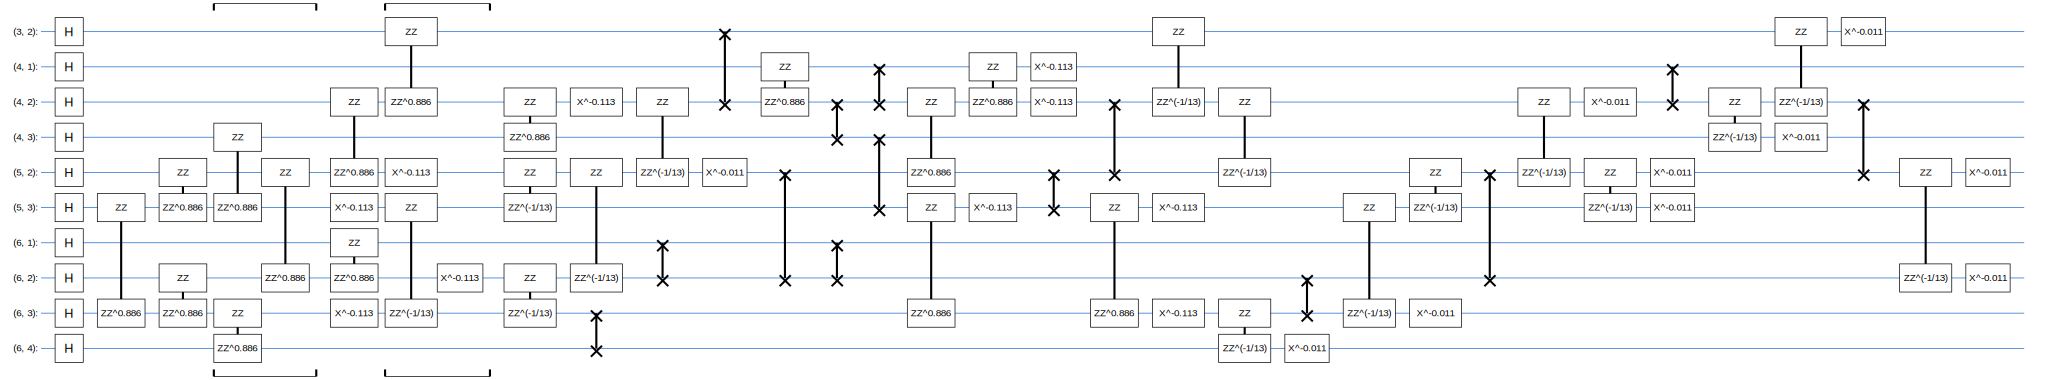

In [20]:
routed_circuit = pytket.cirq.tk_to_cirq(unit.circuit)
routed_circuit = routed_circuit.transform_qubits(lambda q: index_to_qubit[q.x])
SVGCircuit(routed_circuit)

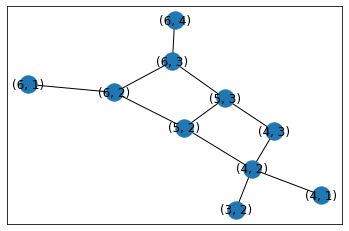

In [21]:
routed_c_graph = ccr.get_circuit_connectivity(routed_circuit)
nx.draw_networkx(routed_c_graph)

In [22]:
for _, op, _ in routed_circuit.findall_operations_with_gate_type(cirq.TwoQubitGate):
    a, b = op.qubits
    assert a.is_adjacent(b)

In [23]:
import cirq.contrib.acquaintance as cca
def permute_gate(qubits, permutation):
    return cca.LinearPermutationGate(
        num_qubits=len(qubits),
        permutation={i: permutation[i] for i in range(len(permutation))}
    ).on(*qubits)

final_to_initial_map = {final_map[cq]: initial_map[cq]
                              for cq in circuit_qubits}
initial_qubits = [initial_map[cq] for cq in circuit_qubits]
final_permutation = [initial_qubits.index(final_to_initial_map[q])
                     for q in initial_qubits]
rcircuit_with_perm = routed_circuit.copy()
rcircuit_with_perm.append(permute_gate(initial_qubits, final_permutation))
expected = circuit.unitary(qubit_order=cirq.QubitOrder.explicit(circuit_qubits))
actual = rcircuit_with_perm.unitary(qubit_order=cirq.QubitOrder.explicit(initial_qubits))
cirq.testing.assert_allclose_up_to_global_phase(expected, actual, atol=1e-8)

In [27]:
len(cirq.Circuit(routed_circuit.all_operations()))

31

In [31]:
len(cirq.Circuit(circuit.all_operations()))

14

In [33]:
len(cirq.Circuit(rcircuit_with_perm.all_operations()))

32

In [11]:
from cirq.contrib.qasm_import import circuit_from_qasm
import cirq.contrib.routing as ccr
import pytket.cirq

def read_qasm_circuit(path):
    qasm_string = open(path, 'r').read()
    try:
        return circuit_from_qasm(qasm_string)
    except:
        print('wrong circuit format')

In [45]:
import pytket
from pytket.circuit import Node
from pytket.predicates import CompilationUnit, ConnectivityPredicate
from pytket.routing import GraphPlacement
from pytket.passes import SequencePass, RoutingPass, DecomposeSwapsToCXs, PlacementPass

def _qubit_index_edges(device):
    index_to_qubit = sorted(device.qubit_set())
    qubit_to_index = {q: i for i, q in enumerate(index_to_qubit)}
    
    dev_graph = ccr.xmon_device_to_graph(device)
    for n1, n2 in dev_graph.edges:
        #yield Node('q', n1.row, n1.col), Node('q', n2.row, n2.col)
        yield (qubit_to_index[n1], qubit_to_index[n2])

def _device_to_tket_device(device):
    arc = pytket.routing.Architecture(
        list(_qubit_index_edges(device))
    )
    print(list(_qubit_index_edges(device)))
    return pytket.device.Device({}, {}, arc)

def _device_connection_list_to_tket_device(device_connection_list):
    arc = pytket.routing.Architecture(device_connection_list)
    return pytket.device.Device({}, {}, arc)

def route_circuit_by_tket(circuit, device_connection_list):
#     index_to_qubit = sorted(device.qubit_set())
#     qubit_to_index = {q: i for i, q in enumerate(index_to_qubit)}
    
    tk_circuit = pytket.cirq.cirq_to_tk(circuit)
    tk_device = _device_connection_list_to_tket_device(device_connection_list)
    
    unit = CompilationUnit(tk_circuit, [ConnectivityPredicate(tk_device)])
#     print(unit.circuit.__repr__())
    passes = SequencePass([
        PlacementPass(GraphPlacement(tk_device)),
        RoutingPass(tk_device, bridge_lookahead=0, bridge_interactions=0)]) # NO BRIDGE
    passes.apply(unit)
    valid = unit.check_all_predicates()
    
    assert valid
    
#     print(unit.circuit.__repr__())
    
    routed_circuit = pytket.cirq.tk_to_cirq(unit.circuit)
#     routed_circuit = routed_circuit.transform_qubits(lambda q: index_to_qubit[q.x])
        
    return routed_circuit

In [46]:
def get_circuit_depth(circuit):
    return len(cirq.Circuit(circuit.all_operations()))

import cirq.google as cg

In [49]:
circuit = read_qasm_circuit('QUEKO-benchmark/BNTF/54QBT_45CYC_QSE_9.qasm')

In [74]:
circuit = read_qasm_circuit('QUEKO-benchmark/BNTF/54QBT_15CYC_QSE_9.qasm')

In [75]:
get_circuit_depth(circuit)


15

In [72]:
routed_circuit = route_circuit_by_tket(circuit, INDEX_CONNECTION_LIST['54QBT'])

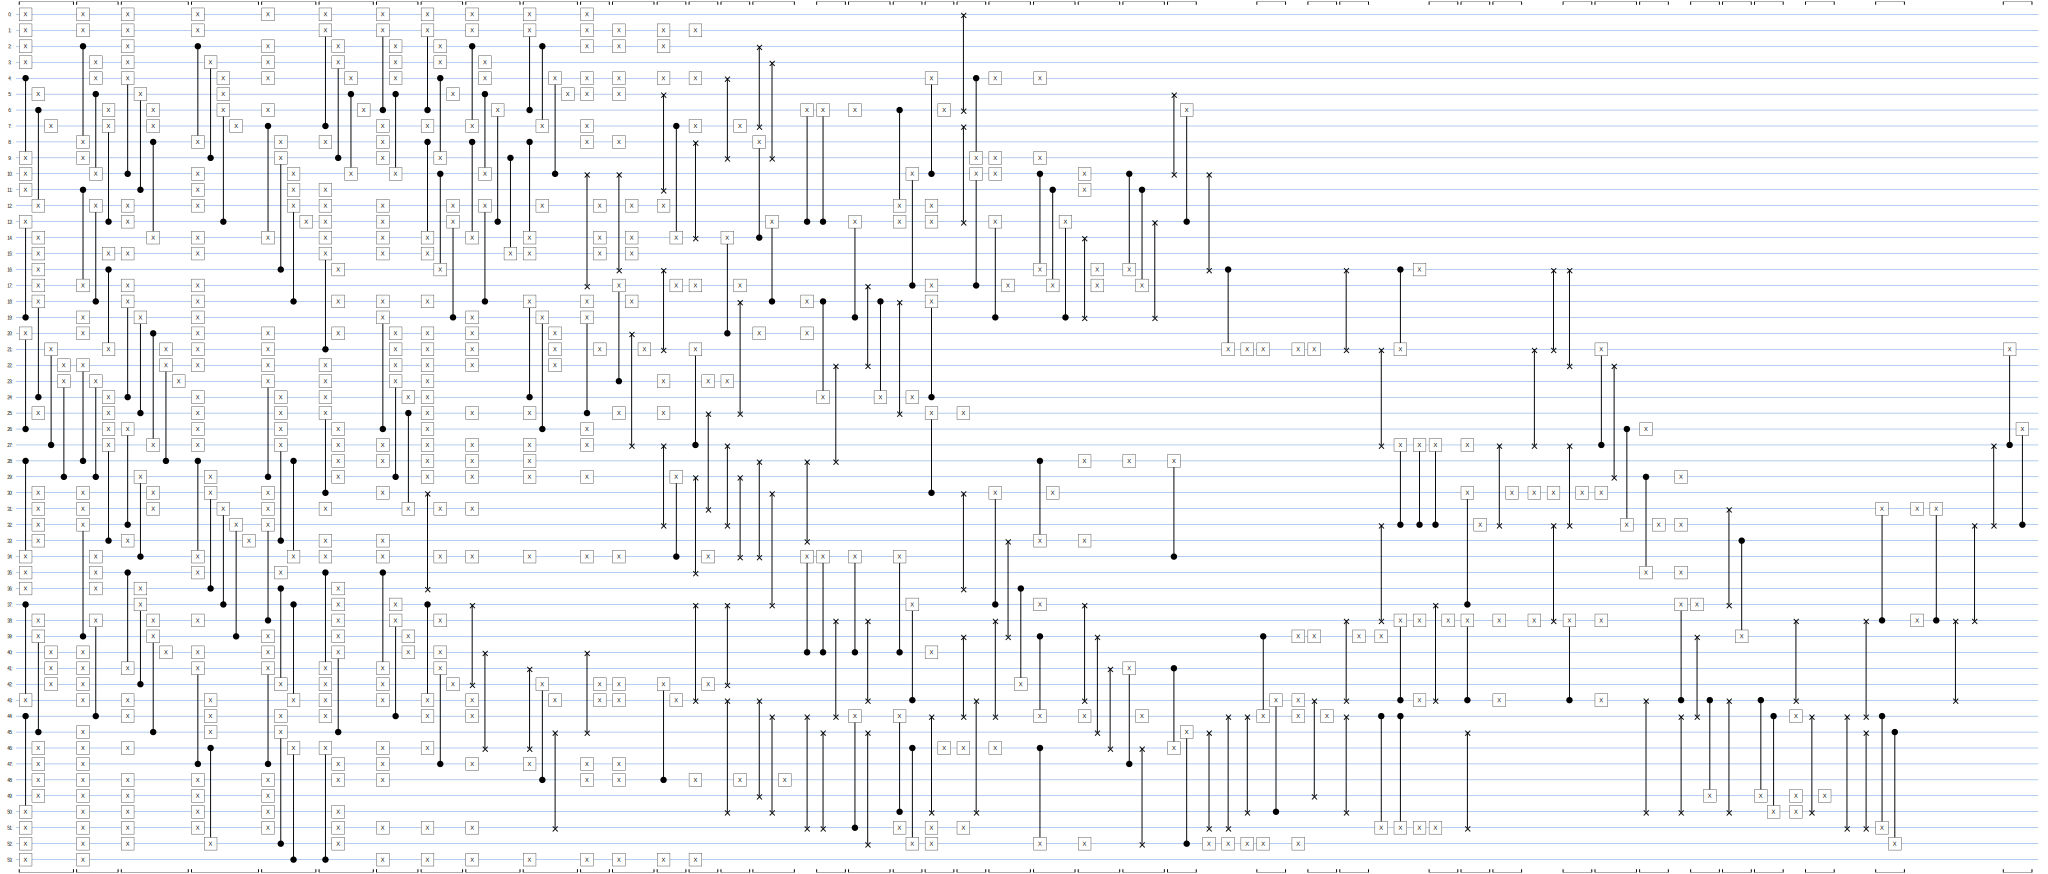

In [76]:
SVGCircuit(routed_circuit)

In [77]:
get_circuit_depth(routed_circuit)

60

In [43]:
INDEX_CONNECTION_LIST = {"Ourense": [(0, 1), (1, 2), (1, 3), (3, 4)],
                       "54QBT": [(0, 6), (1, 6), (1, 7), (2, 7), (2, 8), (3, 8), (3, 9), (4, 9), (4, 10), (5, 10), (5, 11),
                                    (6, 12), (6, 13), (7, 13), (7, 14), (8, 14), (8, 15), (9, 15), (9, 16), (10, 16), (10, 17), (11, 17),
                                    (12, 18), (13, 18), (13, 19), (14, 19), (14, 20), (15, 20), (15, 21), (16, 21), (16, 22), (17, 22), (17, 23),
                                    (18, 24), (18, 25), (19, 25), (19, 26), (20, 26), (20, 27), (21, 27), (21, 28), (22, 28), (22, 29), (23, 29),
                                    (24, 30), (25, 30), (25, 31), (26, 31), (26, 32), (27, 32), (27, 33), (28, 33), (28, 34), (29, 34), (29, 35),
                                    (30, 36), (30, 37), (31, 37), (31, 38), (32, 38), (32, 39), (33, 39), (33, 40), (34, 40), (34, 41), (35, 41),
                                    (36, 42), (37, 42), (37, 43), (38, 43), (38, 44), (39, 44), (39, 45), (40, 45), (40, 46), (41, 46), (41, 47),
                                    (42, 48), (42, 49), (43, 49), (43, 50), (44, 50), (44, 51), (45, 51), (45, 52), (46, 52), (46, 53), (47, 53)],
                       "53QBT": [(0, 1), (1, 2), (2, 3), (3, 4),
                                     (0, 5), (4, 6), (5, 9), (6, 13),
                                     (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15),
                                     (7, 16), (11, 17), (15, 18), (16, 19), (17, 23), (18, 27),
                                     (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27),
                                     (21, 28), (25, 29), (28, 32), (29, 36),
                                     (30, 31), (31, 32), (32, 33), (33, 34), (34, 35), (35, 36), (36, 37), (37, 38),
                                     (30, 39), (34, 40), (38, 41), (39, 42), (40, 46), (41, 50),
                                     (42, 43), (43, 44), (44, 45), (45, 46), (46, 47), (47, 48), (48, 49), (49, 50),
                                     (44, 51), (48, 52)],
                       "20QBT": [(0, 1), (1, 2), (2, 3), (3, 4),
                                 (0, 5), (1, 6), (1, 7), (2, 6), (2, 7), (3, 8), (3, 9), (4, 8), (4, 9),
                                 (5, 6), (6, 7), (7, 8), (8, 9),
                                 (5, 10), (5, 11), (6, 10), (6, 11), (7, 12), (7, 13), (8, 12), (8, 13), (9, 14),
                                 (10, 11), (11, 12), (12, 13), (13, 14),
                                 (10, 15), (11, 16), (11, 17), (12, 16), (12, 17), (13, 18), (13, 19), (14, 18), (14, 19),
                                 (15, 16), (16, 17), (17, 18), (18, 19)],
                       "16QBT": [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7),
                                   (0, 8), (3, 11), (4, 12), (7, 15),
                                   (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15)]
                       }

In [ ]:
import time
import os

result = {}
for device_str in ['16QBT', '20QBT', '53QBT', '54QBT']:
    connection_list = INDEX_CONNECTION_LIST[device_str]
    for folder in ['BIGD', 'BNTF', 'BSS']:
        for file_str in os.listdir('QUEKO-benchmark/' + folder):
            if device_str in file_str:
                start_time = time.time()
                best = int(file_str[6:8])
                circuit = read_qasm_circuit('QUEKO-benchmark/'+folder+'/'+file_str)
                routed_circuit = route_circuit_by_tket(circuit, connection_list)
                compiled = get_circuit_depth(routed_circuit)
                key = folder+'/'+device_str
                result[key] = (best, compiled, compiled / best, time.time() - start_time)
                print(result[key])
                

(5, 5, 1.0, 0.16271615028381348)
(5, 5, 1.0, 0.027803897857666016)
(5, 5, 1.0, 0.1577000617980957)
(5, 5, 1.0, 0.17310357093811035)
(5, 5, 1.0, 0.14433646202087402)
(5, 5, 1.0, 0.14979147911071777)
(5, 5, 1.0, 0.039678335189819336)
(5, 5, 1.0, 0.018877267837524414)
(5, 5, 1.0, 0.12892889976501465)
(5, 5, 1.0, 0.02480006217956543)
(10, 12, 1.2, 0.029787302017211914)
(10, 10, 1.0, 0.026755094528198242)
(10, 13, 1.3, 0.044135093688964844)
(10, 10, 1.0, 0.028272151947021484)
(10, 10, 1.0, 0.023311853408813477)
(10, 10, 1.0, 0.024799823760986328)
(10, 10, 1.0, 0.02430438995361328)
(10, 10, 1.0, 0.026287555694580078)
(10, 10, 1.0, 0.040673017501831055)
(10, 10, 1.0, 0.03673243522644043)
(15, 15, 1.0, 0.0381627082824707)
(15, 16, 1.0666666666666667, 0.031249284744262695)
(15, 15, 1.0, 0.0367276668548584)
(15, 15, 1.0, 0.0332331657409668)
(15, 15, 1.0, 0.031717777252197266)
(15, 21, 1.4, 0.03372955322265625)
(15, 24, 1.6, 0.037199974060058594)
(15, 24, 1.6, 0.037695884704589844)
(15, 22, 1.466

(45, 85, 1.8888888888888888, 0.2737925052642822)
(45, 73, 1.6222222222222222, 0.3139324188232422)
(45, 69, 1.5333333333333334, 0.9721589088439941)
(45, 72, 1.6, 0.7430069446563721)
(45, 64, 1.4222222222222223, 0.5966892242431641)
(45, 81, 1.8, 0.3591032028198242)
(45, 64, 1.4222222222222223, 0.5704231262207031)
(45, 94, 2.088888888888889, 0.43149518966674805)
(45, 80, 1.7777777777777777, 0.22220778465270996)
(45, 92, 2.0444444444444443, 0.3204174041748047)
(45, 84, 1.8666666666666667, 0.38092637062072754)
(45, 87, 1.9333333333333333, 0.5163357257843018)
(45, 68, 1.511111111111111, 0.6185128688812256)
(45, 98, 2.1777777777777776, 1.291085958480835)
(45, 84, 1.8666666666666667, 0.7787203788757324)
(45, 90, 2.0, 0.30851173400878906)
(45, 107, 2.3777777777777778, 0.9175984859466553)
(45, 106, 2.3555555555555556, 0.21228861808776855)
(45, 110, 2.4444444444444446, 0.9974546432495117)
(45, 113, 2.511111111111111, 1.2057757377624512)
(45, 107, 2.3777777777777778, 0.29958319664001465)
(45, 103,

(45, 108, 2.4, 0.14981913566589355)
(45, 115, 2.5555555555555554, 1.1219229698181152)
(45, 54, 1.2, 0.19840073585510254)
(45, 50, 1.1111111111111112, 0.7102713584899902)
(45, 128, 2.8444444444444446, 0.20884346961975098)
(45, 135, 3.0, 0.512836217880249)
(45, 121, 2.688888888888889, 0.5872633457183838)
(45, 57, 1.2666666666666666, 0.2167506217956543)
(45, 73, 1.6222222222222222, 0.2480008602142334)
(45, 76, 1.6888888888888889, 0.21328043937683105)
(45, 56, 1.2444444444444445, 0.23163104057312012)
(45, 80, 1.7777777777777777, 0.19046425819396973)
(45, 50, 1.1111111111111112, 0.2569265365600586)
(45, 64, 1.4222222222222223, 0.19192051887512207)
(45, 56, 1.2444444444444445, 0.20137453079223633)
(45, 67, 1.488888888888889, 0.23857617378234863)
(45, 73, 1.6222222222222222, 0.3219332695007324)
(45, 70, 1.5555555555555556, 0.34667468070983887)
(45, 89, 1.9777777777777779, 1.0594549179077148)
(45, 68, 1.511111111111111, 0.3253750801086426)
(45, 64, 1.4222222222222223, 0.2897202968597412)
(45, 

(30, 918, 30.6, 3.1828298568725586)
(30, 315, 10.5, 1.2166874408721924)
(30, 315, 10.5, 1.023742914199829)
(30, 938, 31.266666666666666, 5.560153961181641)
(30, 730, 24.333333333333332, 1.967127799987793)
(30, 609, 20.3, 1.9755666255950928)
(30, 969, 32.3, 1.970604419708252)
(30, 971, 32.36666666666667, 1.588688611984253)
(40, 1287, 32.175, 1.926957130432129)
(40, 1182, 29.55, 1.9874694347381592)
(40, 1257, 31.425, 1.6740000247955322)
(40, 1445, 36.125, 1.4954383373260498)
(40, 1243, 31.075, 1.659614086151123)
(40, 405, 10.125, 3.307821273803711)
(40, 1102, 27.55, 1.6363310813903809)
(40, 1255, 31.375, 2.302401065826416)
(40, 1436, 35.9, 1.8347022533416748)
(40, 1327, 33.175, 2.047485113143921)
(50, 1455, 29.1, 4.654461145401001)
(50, 543, 10.86, 2.1848769187927246)
(50, 860, 17.2, 2.3842990398406982)
(50, 563, 11.26, 2.5181620121002197)
(50, 1419, 28.38, 2.733949661254883)
(50, 868, 17.36, 6.457418441772461)
(50, 729, 14.58, 2.8862204551696777)
(50, 1699, 33.98, 2.2553112506866455)
(5

In [ ]:
result

In [35]:
import pytket.cirq

In [54]:
cg.Sycamore23

                  (3, 2)
                  │
                  │
         (4, 1)───(4, 2)───(4, 3)
         │        │        │
         │        │        │
(5, 0)───(5, 1)───(5, 2)───(5, 3)───(5, 4)
         │        │        │        │
         │        │        │        │
         (6, 1)───(6, 2)───(6, 3)───(6, 4)───(6, 5)
                  │        │        │        │
                  │        │        │        │
                  (7, 2)───(7, 3)───(7, 4)───(7, 5)───(7, 6)
                           │        │        │
                           │        │        │
                           (8, 3)───(8, 4)───(8, 5)
                                    │
                                    │
                                    (9, 4)

In [79]:
import os
os.listdir('QUEKO-benchmark/BIGD')

['20QBT_45CYC_.0D1_.1D2_0.qasm',
 '20QBT_45CYC_.0D1_.1D2_1.qasm',
 '20QBT_45CYC_.0D1_.1D2_2.qasm',
 '20QBT_45CYC_.0D1_.1D2_3.qasm',
 '20QBT_45CYC_.0D1_.1D2_4.qasm',
 '20QBT_45CYC_.0D1_.1D2_5.qasm',
 '20QBT_45CYC_.0D1_.1D2_6.qasm',
 '20QBT_45CYC_.0D1_.1D2_7.qasm',
 '20QBT_45CYC_.0D1_.1D2_8.qasm',
 '20QBT_45CYC_.0D1_.1D2_9.qasm',
 '20QBT_45CYC_.0D1_.2D2_0.qasm',
 '20QBT_45CYC_.0D1_.2D2_1.qasm',
 '20QBT_45CYC_.0D1_.2D2_2.qasm',
 '20QBT_45CYC_.0D1_.2D2_3.qasm',
 '20QBT_45CYC_.0D1_.2D2_4.qasm',
 '20QBT_45CYC_.0D1_.2D2_5.qasm',
 '20QBT_45CYC_.0D1_.2D2_6.qasm',
 '20QBT_45CYC_.0D1_.2D2_7.qasm',
 '20QBT_45CYC_.0D1_.2D2_8.qasm',
 '20QBT_45CYC_.0D1_.2D2_9.qasm',
 '20QBT_45CYC_.0D1_.3D2_0.qasm',
 '20QBT_45CYC_.0D1_.3D2_1.qasm',
 '20QBT_45CYC_.0D1_.3D2_2.qasm',
 '20QBT_45CYC_.0D1_.3D2_3.qasm',
 '20QBT_45CYC_.0D1_.3D2_4.qasm',
 '20QBT_45CYC_.0D1_.3D2_5.qasm',
 '20QBT_45CYC_.0D1_.3D2_6.qasm',
 '20QBT_45CYC_.0D1_.3D2_7.qasm',
 '20QBT_45CYC_.0D1_.3D2_8.qasm',
 '20QBT_45CYC_.0D1_.3D2_9.qasm',
 '20QBT_45

In [37]:
qasm_string = open('umfg/QUEKO_results/16QBT_05CYC_TFL_0.qasm', 'r').read()

In [23]:
result = circuit_from_qasm(qasm_string)

In [26]:
get_circuit_depth(result)

19

In [33]:
import os
file = open('run_all.sh', 'w', newline='\n')
for fname in os.listdir('QUEKO-benchmark/BNTF'):
    if fname[:2] != '16': continue
    cmd_str = f'enfield/build/tools/efd -i QUEKO-benchmark/BNTF/{fname}  -alloc wpm -arch ibmqx3 --rev-cost 8 --swap-cost 20 --lcx-cost 22 -stats -o QUEKO_results/{fname}\n'
    file.write(cmd_str)

In [40]:
def read_umfg_qasm_circuit(path):
    qasm_string = open(path, 'r').read()
    qasm_string = 'OPENQASM 2.0;\n' + qasm_string.replace('gate intrinsic_swap__ a, b {\n\tcx a, b;\n\tcx b, a;\n\tcx a, b;\n}\ngate intrinsic_rev_cx__ a, b {\n\th a;\n\th b;\n\tcx b, a;\n\th b;\n\th a;\n}\n', '').replace('intrinsic_swap__', 'swap').replace('intrinsic_rev_cx__', 'cx')
    try:
        return circuit_from_qasm(qasm_string)
    except:
        print('wrong circuit format')

In [52]:
q16_results = {}

In [59]:
import time
import os

result = {}
for device_str in ['16QBT']:
    connection_list = INDEX_CONNECTION_LIST[device_str]
    for folder in ['BNTF']:
        for file_str in os.listdir('QUEKO-benchmark/' + folder):
            if device_str in file_str:
                start_time = time.time()
                best = int(file_str[6:8])
                circuit = read_qasm_circuit('QUEKO-benchmark/'+folder+'/'+file_str)
                routed_circuit = route_circuit_by_tket(circuit, connection_list)
                compiled = get_circuit_depth(routed_circuit)
                key = folder+'/'+device_str
                result[key] = (best, compiled, compiled / best, time.time() - start_time)
#                 print(result[key])
                print(file_str, compiled)
                q16_results[file_str] = [best, compiled, 0]
                

16QBT_05CYC_TFL_0.qasm 5
16QBT_05CYC_TFL_1.qasm 5
16QBT_05CYC_TFL_2.qasm 5
16QBT_05CYC_TFL_3.qasm 5
16QBT_05CYC_TFL_4.qasm 5
16QBT_05CYC_TFL_5.qasm 5
16QBT_05CYC_TFL_6.qasm 5
16QBT_05CYC_TFL_7.qasm 5
16QBT_05CYC_TFL_8.qasm 5
16QBT_05CYC_TFL_9.qasm 5
16QBT_10CYC_TFL_0.qasm 12
16QBT_10CYC_TFL_1.qasm 10
16QBT_10CYC_TFL_2.qasm 13
16QBT_10CYC_TFL_3.qasm 10
16QBT_10CYC_TFL_4.qasm 10
16QBT_10CYC_TFL_5.qasm 10
16QBT_10CYC_TFL_6.qasm 10
16QBT_10CYC_TFL_7.qasm 10
16QBT_10CYC_TFL_8.qasm 10
16QBT_10CYC_TFL_9.qasm 10
16QBT_15CYC_TFL_0.qasm 15
16QBT_15CYC_TFL_1.qasm 16
16QBT_15CYC_TFL_2.qasm 15
16QBT_15CYC_TFL_3.qasm 15
16QBT_15CYC_TFL_4.qasm 15
16QBT_15CYC_TFL_5.qasm 21
16QBT_15CYC_TFL_6.qasm 24
16QBT_15CYC_TFL_7.qasm 24
16QBT_15CYC_TFL_8.qasm 22
16QBT_15CYC_TFL_9.qasm 18
16QBT_20CYC_TFL_0.qasm 37
16QBT_20CYC_TFL_1.qasm 20
16QBT_20CYC_TFL_2.qasm 29
16QBT_20CYC_TFL_3.qasm 27
16QBT_20CYC_TFL_4.qasm 34
16QBT_20CYC_TFL_5.qasm 23
16QBT_20CYC_TFL_6.qasm 37
16QBT_20CYC_TFL_7.qasm 20
16QBT_20CYC_TFL_8.qasm

In [60]:
import os
for fname in os.listdir('umfg\QUEKO_results'):
    circuit = read_umfg_qasm_circuit(f'umfg\QUEKO_results\{fname}')
    print(fname, get_circuit_depth(circuit))
    q16_results[fname][2] = get_circuit_depth(circuit)

16QBT_05CYC_TFL_0.qasm 19
16QBT_05CYC_TFL_1.qasm 26
16QBT_05CYC_TFL_2.qasm 9
16QBT_05CYC_TFL_3.qasm 11
16QBT_05CYC_TFL_4.qasm 13
16QBT_05CYC_TFL_5.qasm 23
16QBT_05CYC_TFL_6.qasm 23
16QBT_05CYC_TFL_7.qasm 19
16QBT_05CYC_TFL_8.qasm 17
16QBT_05CYC_TFL_9.qasm 22
16QBT_10CYC_TFL_0.qasm 23
16QBT_10CYC_TFL_1.qasm 38
16QBT_10CYC_TFL_2.qasm 29
16QBT_10CYC_TFL_3.qasm 45
16QBT_10CYC_TFL_4.qasm 44
16QBT_10CYC_TFL_5.qasm 39
16QBT_10CYC_TFL_6.qasm 26
16QBT_10CYC_TFL_7.qasm 40
16QBT_10CYC_TFL_8.qasm 27
16QBT_10CYC_TFL_9.qasm 30
16QBT_15CYC_TFL_0.qasm 45
16QBT_15CYC_TFL_1.qasm 41
16QBT_15CYC_TFL_2.qasm 76
16QBT_15CYC_TFL_3.qasm 48
16QBT_15CYC_TFL_4.qasm 57
16QBT_15CYC_TFL_5.qasm 38
16QBT_15CYC_TFL_6.qasm 54
16QBT_15CYC_TFL_7.qasm 37
16QBT_15CYC_TFL_8.qasm 67
16QBT_15CYC_TFL_9.qasm 38
16QBT_20CYC_TFL_0.qasm 67
16QBT_20CYC_TFL_1.qasm 50
16QBT_20CYC_TFL_2.qasm 58
16QBT_20CYC_TFL_3.qasm 76
16QBT_20CYC_TFL_4.qasm 52
16QBT_20CYC_TFL_5.qasm 73
16QBT_20CYC_TFL_6.qasm 71
16QBT_20CYC_TFL_7.qasm 80
16QBT_20CYC_T

In [61]:
q16_results

{'16QBT_05CYC_TFL_0.qasm': [5, 5, 19],
 '16QBT_05CYC_TFL_1.qasm': [5, 5, 26],
 '16QBT_05CYC_TFL_2.qasm': [5, 5, 9],
 '16QBT_05CYC_TFL_3.qasm': [5, 5, 11],
 '16QBT_05CYC_TFL_4.qasm': [5, 5, 13],
 '16QBT_05CYC_TFL_5.qasm': [5, 5, 23],
 '16QBT_05CYC_TFL_6.qasm': [5, 5, 23],
 '16QBT_05CYC_TFL_7.qasm': [5, 5, 19],
 '16QBT_05CYC_TFL_8.qasm': [5, 5, 17],
 '16QBT_05CYC_TFL_9.qasm': [5, 5, 22],
 '16QBT_10CYC_TFL_0.qasm': [10, 12, 23],
 '16QBT_10CYC_TFL_1.qasm': [10, 10, 38],
 '16QBT_10CYC_TFL_2.qasm': [10, 13, 29],
 '16QBT_10CYC_TFL_3.qasm': [10, 10, 45],
 '16QBT_10CYC_TFL_4.qasm': [10, 10, 44],
 '16QBT_10CYC_TFL_5.qasm': [10, 10, 39],
 '16QBT_10CYC_TFL_6.qasm': [10, 10, 26],
 '16QBT_10CYC_TFL_7.qasm': [10, 10, 40],
 '16QBT_10CYC_TFL_8.qasm': [10, 10, 27],
 '16QBT_10CYC_TFL_9.qasm': [10, 10, 30],
 '16QBT_15CYC_TFL_0.qasm': [15, 15, 45],
 '16QBT_15CYC_TFL_1.qasm': [15, 16, 41],
 '16QBT_15CYC_TFL_2.qasm': [15, 15, 76],
 '16QBT_15CYC_TFL_3.qasm': [15, 15, 48],
 '16QBT_15CYC_TFL_4.qasm': [15, 15, 5

In [39]:
'OPENQASM 2.0;\n' + qasm_string.replace('gate intrinsic_swap__ a, b {\n\tcx a, b;\n\tcx b, a;\n\tcx a, b;\n}\ngate intrinsic_rev_cx__ a, b {\n\th a;\n\th b;\n\tcx b, a;\n\th b;\n\th a;\n}\n', '').replace('intrinsic_swap__', 'swap').replace('intrinsic_rev_cx__', 'cx')

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[16];\nu3(pi, 0, pi) q[1];\nu3(pi, 0, pi) q[10];\nu3(pi, 0, pi) q[7];\nu3(pi, 0, pi) q[13];\nu3(pi, 0, pi) q[8];\nu3(pi, 0, pi) q[2];\nu3(pi, 0, pi) q[3];\ncx q[4], q[5];\ncx q[0], q[15];\nu3(pi, 0, pi) q[1];\nu3(pi, 0, pi) q[5];\nu3(pi, 0, pi) q[12];\nu3(pi, 0, pi) q[4];\nu3(pi, 0, pi) q[11];\nu3(pi, 0, pi) q[7];\nu3(pi, 0, pi) q[14];\ncx q[9], q[10];\ncx q[0], q[15];\ncx q[2], q[3];\nu3(pi, 0, pi) q[7];\nu3(pi, 0, pi) q[15];\ncx q[0], q[1];\ncx q[4], q[5];\ncx q[6], q[11];\nswap q[8], q[7];\nswap q[7], q[10];\nswap q[11], q[10];\nswap q[12], q[11];\nswap q[12], q[13];\nswap q[13], q[14];\ncx q[3], q[14];\nswap q[9], q[10];\nswap q[11], q[10];\nswap q[12], q[11];\nswap q[12], q[13];\nswap q[13], q[14];\nswap q[3], q[14];\ncx q[2], q[3];\nu3(pi, 0, pi) q[3];\ncx q[0], q[15];\nswap q[3], q[14];\ncx q[2], q[3];\ncx q[8], q[9];\nu3(pi, 0, pi) q[12];\nu3(pi, 0, pi) q[8];\nu3(pi, 0, pi) q[3];\nu3(pi, 0, pi) q[5];\nu3(pi, 0, pi) q[13];\ncx q[0], q

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

In [71]:
X1 = list(map(lambda x: x[0], list(q16_results.values())))

In [72]:
Y1 = list(map(lambda x: x[1], list(q16_results.values())))

In [73]:
Y2 = list(map(lambda x: x[2], list(q16_results.values())))

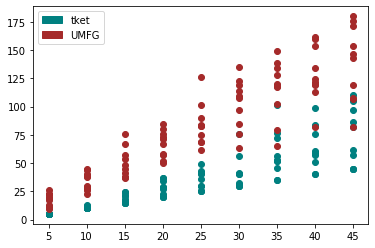

In [79]:
fig, ax = plt.subplots()
ax.plot(X1, Y1, 'o', color='teal')
ax.plot(X1, Y2, 'o', color='brown')
teal_patch = mpatches.Patch(color='teal', label='tket')
brown_patch = mpatches.Patch(color='brown', label='UMFG')
ax.legend(handles=[teal_patch, brown_patch])
